In [25]:
import torch.optim as optim
import torch.nn as nn
import torch
import torch.nn.functional as F
import numpy as np
import gzip


In [26]:
torch.manual_seed(42)

In [27]:
def training_images():
    with gzip.open('/content/train-images-idx3-ubyte.gz', 'r') as f:
        # first 4 bytes is a magic number
        magic_number = int.from_bytes(f.read(4), 'big')
        # second 4 bytes is the number of images
        image_count = int.from_bytes(f.read(4), 'big')
        # third 4 bytes is the row count
        row_count = int.from_bytes(f.read(4), 'big')
        # fourth 4 bytes is the column count
        column_count = int.from_bytes(f.read(4), 'big')
        # rest is the image pixel data, each pixel is stored as an unsigned byte
        # pixel values are 0 to 255
        image_data = f.read()
        images = np.frombuffer(image_data, dtype=np.uint8)\
            .reshape((image_count, row_count, column_count))
        return images


def training_labels():
    with gzip.open('/content/train-labels-idx1-ubyte.gz', 'r') as f:
        # first 4 bytes is a magic number
        magic_number = int.from_bytes(f.read(4), 'big')
        # second 4 bytes is the number of labels
        label_count = int.from_bytes(f.read(4), 'big')
        # rest is the label data, each label is stored as unsigned byte
        # label values are 0 to 9
        label_data = f.read()
        labels = np.frombuffer(label_data, dtype=np.uint8)
        return labels

In [28]:
x_train = training_images()
x_train.shape

(60000, 28, 28)

In [29]:
x_train = x_train.reshape(60000,1, 28, 28)
x_train.shape

(60000, 1, 28, 28)

In [30]:
y_train = training_labels()
y_train.shape

(60000,)

In [31]:
x_s=torch.tensor(x_train).type(torch.FloatTensor)
y_s=torch.tensor(y_train)

**CNN**

In [32]:
class CNN(nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv1_bn=nn.BatchNorm2d(10)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_bn=nn.BatchNorm2d(20)

        
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

        self.conv2_drop = nn.Dropout2d()
        self.Softmax = torch.nn.Softmax(dim=1)

        self.conv1_bn=nn.BatchNorm2d(10)
        self.conv2_bn=nn.BatchNorm2d(20)
        #self.conv3_bn=nn.BatchNorm2d(64)
        
        
        #self.fc1_bn=nn.BatchNorm1d(50)
        #self.dp = torch.nn.Dropout(p = 0.2)
        

    def forward(self, x):

        #x = F.max_pool2d(self.conv1(x), 2)
        #x = F.relu(x)

        #x = self.conv2_drop(self.conv2(x))
        #x = F.relu(x)
        #x = F.relu(F.max_pool2d(self.conv1(x), 2))
        #x = F.relu(F.max_pool2d(self.conv2(x), 2))
        #x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))

        x=F.max_pool2d(self.conv1(x), 2)
        x=self.conv1_bn(x)
        x=F.relu(x)

        x=F.max_pool2d(self.conv2_drop(self.conv2(x)), 2)
        x=self.conv2_bn(x)
        x=F.relu(x)
        
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        #x = self.dp(x)

        #x=self.fc1(x)
        #x= F.relu(self.fc1_bn(x))

        x = self.fc2(x)
        x = self.Softmax(x)

       
        return x

In [33]:
n_epochs = 30  
learning_rate = 0.01
loss_model = torch.nn.CrossEntropyLoss()

model_CNN = CNN()
optimizer = torch.optim.SGD(model_CNN .parameters(), lr=learning_rate)

In [34]:
torch.cuda.is_available()

False

In [35]:
train_losses = []
train_counter = []

In [36]:
train_predict=[]
for epoch in range(1, n_epochs+1):

    #model_SR.train()
    model_CNN.train()
    
    optimizer.zero_grad()

    #output = model_SR(x_s)
    output = model_CNN(x_s)

    loss = loss_model(output, y_s)
    predictions = torch.max(output, 1) ##converting the output probabilities to predicted class

    loss.backward()
    optimizer.step()
    print("epoch: ", epoch)
    train_predict.append(output)

    train_losses.append(loss)
    train_counter.append(epoch)

    #print("epoch:",epoch," loss:",loss)


epoch:  1
epoch:  2
epoch:  3
epoch:  4
epoch:  5
epoch:  6
epoch:  7
epoch:  8
epoch:  9
epoch:  10
epoch:  11
epoch:  12
epoch:  13
epoch:  14
epoch:  15
epoch:  16
epoch:  17
epoch:  18
epoch:  19
epoch:  20
epoch:  21
epoch:  22
epoch:  23
epoch:  24
epoch:  25
epoch:  26
epoch:  27
epoch:  28
epoch:  29
epoch:  30


In [37]:
def classlabel(z):
    return z.argmax(axis=1)

In [38]:
accuracy=[]
for j in range(len(train_predict)):
    count = 0
    predict = classlabel(train_predict[j])

    for k in range(len(predict)):
        if predict[k] == y_s[k]:
             count+= 1
    
    accuracy.append(count/len(predict))
print("Train Accuracy: ",count/len(predict))

Train Accuracy:  0.09216666666666666


Plot-Accuracy

Text(0.5, 1.0, 'CNN -  batch normalization')

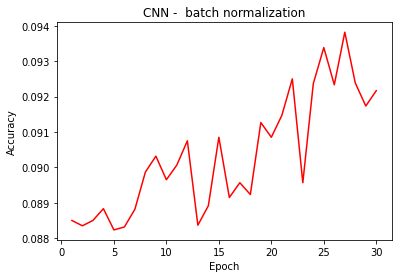

In [48]:
import matplotlib.pyplot as plt
plt.plot(train_counter, accuracy, color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('CNN -  batch normalization')

Plot-Loss

Text(0.5, 1.0, 'CNN - batch normalization')

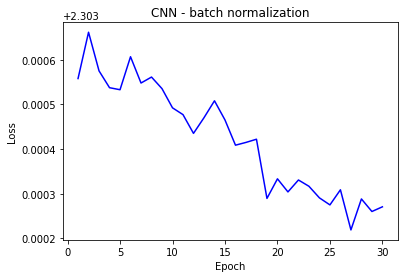

In [49]:
import matplotlib.pyplot as plt
loss_list = []

for i in range (len(train_losses)):
  loss_list.append(float(train_losses[i]))

plt.plot(train_counter, loss_list, color='blue')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('CNN - batch normalization')

In [41]:
def testing_images():
    with gzip.open('/content/t10k-images-idx3-ubyte.gz', 'r') as f:
        # first 4 bytes is a magic number
        magic_number = int.from_bytes(f.read(4), 'big')
        # second 4 bytes is the number of images
        image_count = int.from_bytes(f.read(4), 'big')
        # third 4 bytes is the row count
        row_count = int.from_bytes(f.read(4), 'big')
        # fourth 4 bytes is the column count
        column_count = int.from_bytes(f.read(4), 'big')
        # rest is the image pixel data, each pixel is stored as an unsigned byte
        # pixel values are 0 to 255
        image_data = f.read()
        images = np.frombuffer(image_data, dtype=np.uint8)\
            .reshape((image_count, row_count, column_count))
        return images


def testing_labels():
    with gzip.open('/content/t10k-labels-idx1-ubyte.gz', 'r') as f:
        # first 4 bytes is a magic number
        magic_number = int.from_bytes(f.read(4), 'big')
        # second 4 bytes is the number of labels
        label_count = int.from_bytes(f.read(4), 'big')
        # rest is the label data, each label is stored as unsigned byte
        # label values are 0 to 9
        label_data = f.read()
        labels = np.frombuffer(label_data, dtype=np.uint8)
        return labels

In [42]:
x_test = testing_images()
x_test.shape

(10000, 28, 28)

In [43]:
y_test = testing_labels()
y_test.shape

(10000,)

In [44]:
x_st = x_test.reshape(10000,1,28,28)

In [45]:
x_st=torch.tensor(x_st).type(torch.FloatTensor)
y_st=torch.tensor(y_test)

In [46]:
def test():

  #model_SR.eval()
  model_CNN.eval()

  #test_loss = 0
  correct = 0


  output = model_CNN(x_st)
  #output = model_MLP(x_st)
  y_predict = classlabel(output) 

  for k in range(len(y_predict)):
    
    if y_predict[k] == y_test[k]:
      correct+= 1
  #test_loss = loss_fn(output, y_test)
  #test_losses.append(test_loss)

  #print(" test_loss:",test_loss)
  print("Test Accuracy: ",correct/len(y_test))

In [47]:
test()

Test Accuracy:  0.1141
